# Setup

In [2]:
# !pip install -q tensorflow-gpu==2.0.0-alpha0

In [3]:
import tensorflow as tf

In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import numpy as np
import os
import PIL
from tensorflow.keras import layers, Sequential
import time
from IPython import display


In [5]:
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

# Digit to Image

In [6]:
import cv2

ModuleNotFoundError: No module named 'cv2'

In [0]:
def digit_to_image(digit : int):
    fig = plt.figure(figsize=(1,1))
    canvas = FigureCanvas(fig)
    ax = plt.gca()
    fig.patch.set_facecolor('black')
    plt.axis('off')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.text(0.25 + random.random() / 2, 0.25 + random.random() / 2, str(int(digit)),
             size=48,
             color='white',
             clip_box=ax.clipbox,
             clip_on=True,
             horizontalalignment = 'center',
             verticalalignment = 'center',
             linespacing = 0,
             #bbox=dict(facecolor='red', alpha=0.5),
             transform=ax.transAxes)
    #plt.savefig(f'{digit}.png', pad_inches=0, facecolor='black')
    canvas.draw()
    width, height = fig.get_size_inches() * fig.get_dpi()
    image = color.rgb2gray(np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3))
    plt.close(fig)
    return cv2.resize(image, dsize=(64,64)).astype(np.float32)

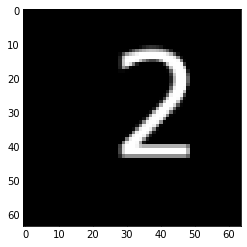

In [0]:
plt.imshow(digit_to_image(2), cmap="gray")

# Training MNIST

In [0]:
import cv2

In [0]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [0]:
train_images = np.stack([cv2.resize(image, dsize=(64, 64)).astype('float32') for image in train_images], 0)
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128

In [0]:
model = Sequential([
    layers.Flatten(input_shape=(64, 64)),
    layers.Dense(256, activation=tf.nn.relu),
    layers.Dense(10, activation=tf.nn.softmax)
])

In [0]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 21s 357us/sample - loss: 0.3405 - accuracy: 0.9009
Epoch 2/5
60000/60000 [==============================] - 22s 361us/sample - loss: 0.1902 - accuracy: 0.9424
Epoch 3/5
60000/60000 [==============================] - 21s 354us/sample - loss: 0.1617 - accuracy: 0.9513
Epoch 4/5
60000/60000 [==============================] - 22s 362us/sample - loss: 0.1429 - accuracy: 0.9572
Epoch 5/5
60000/60000 [==============================] - 22s 361us/sample - loss: 0.1341 - accuracy: 0.9599


# Phosphenes

In [0]:
#!/usr/bin/env python

import numpy as np
from scipy.ndimage import gaussian_filter
import random
import math
from skimage import color

# from scipy.ndimages.filters import convolve

# CONSTANTS

XSIZE = 64
YSIZE = 64
PBASE = 1
SCALE = 6
EXSIZE = XSIZE // SCALE
EYSIZE = YSIZE // SCALE


def safebound(value: float, width: float, lower: float, upper: float):
    """ 
    Returns the bounded min and max about value with width.
    """
    vmin = int(max(lower, value - width))
    vmax = int(min(upper, value + width))
    return vmin, vmax

def bound(value:float, lower: float, upper:float):
    """
    Returns a bounded value.
    """
    if value > lower:
        if value < upper:
            return value
        else:
            return upper
    else:
        return lower

# Electrodes, which produce phosphenes.

class Electrode:
    def __init__(self, x: float, y: float, xsize : int = XSIZE, ysize : int = YSIZE, randomPos: float = 0):
        """
        Produces a phosphene for a single electrode.
        
        Args:
            x: float         - position in range [0, 1]. 
            y: float         - position in range [0, 1]
            randomPos: float - a scaling factor for random positioning. 
        """
        self.randomPos = randomPos
        self.x = bound(x + (random.random() - 0.5) * self.randomPos, 0, 1)
        self.y = bound(y + (random.random() - 0.5) * self.randomPos, 0, 1)
        self.xsize = xsize
        self.ysize = ysize

        self.size = PBASE * (0.5 + (4 * np.sqrt((self.x - 0.5) ** 2 + (self.y - 0.5) ** 2)) ** 2)

        self.rendered = self.render()

    def render(self):
        xmin, xmax = safebound(self.xsize * self.x, self.size, 0, self.xsize)
        ymin, ymax = safebound(self.ysize * self.y, self.size, 0, self.ysize)

        base = np.zeros((self.ysize, self.xsize))
        base[ymin:ymax, xmin:xmax] = 1

        return gaussian_filter(base, self.size)

class PolarRegularGrid:
    def __init__(self, nrho, ntheta, xsize=XSIZE, ysize=YSIZE):
        self.nrho   = nrho
        self.ntheta = ntheta
        self.grid = [
            # Need to think of better way to scale.
            Electrode(((math.exp(rho**0.6) / math.exp(nrho**0.6) * math.cos((math.pi * theta / ntheta) - math.pi/2)) + 1) / 2,
                      ((math.exp(rho**0.6) / math.exp(nrho**0.6) * math.sin((math.pi * theta / ntheta) - math.pi/2)) + 1) / 2,
                      xsize = xsize,
                      ysize = ysize,
                     )
            # Ensure the central electrodes are actually visible by adding 1 to zero.
            for rho in range(1, nrho+1)
            for theta in range(ntheta)
        ]
        
        self.renders = tf.convert_to_tensor(np.array([e.rendered for e in self.grid]), dtype=tf.float32)

    def render(self, values):
        product = [v * e.rendered for (v, e) in zip(values, self.grid)]
        summed = sum(product)
        summax = np.max(summed)
        return np.clip(summed, 0, 1) * 2 - 1
        # return (summed / summax) * 2 - 1
        
    def render_tensor(self, tensor):
        reshaped = tf.transpose(tf.reshape(tf.tile(tensor, tf.constant([64])), (64, 144, 1)), perm=[1, 0, 2])
        product = reshaped * self.renders
        summed = tf.reduce_sum(product, axis=0)
        return tf.clip_by_value(summed, 0, 1) * 2 - 1
      
class UniqueElectrode:
    """
    This class implements electrodes with unique characteristics such as colour and shape.
    """
    def __init__(self, x: float, y: float, xsize : int = XSIZE, ysize : int = YSIZE, randomPos: float = 0.001):
        self.x = bound(x + (random.random() - 0.5) * randomPos, 0, 1)
        self.y = bound(y + (random.random() - 0.5) * randomPos, 0, 1)
        self.size = PBASE * (0.5 + (4 * np.sqrt((self.x - 0.5) ** 2 + (self.y - 0.5) ** 2)) ** 2)
        self.brightness = random.random()
        # xmod and ymod modify the shape of the phosphene
        self.xmod = 1 + (random.random()-0.5) * 3
        self.ymod = 1 + (random.random()-0.5) * 3
        self.xsize = xsize
        self.ysize = ysize

        self.rendered = self.render()

    def render(self):
        xmin, xmax = safebound(self.xsize * self.x, self.size*self.xmod, 0, self.xsize)
        ymin, ymax = safebound(self.ysize * self.y, self.size*self.ymod, 0, self.ysize)

        base = np.zeros((self.ysize, self.xsize))
        base[ymin:ymax, xmin:xmax] = self.brightness

        return gaussian_filter(base, self.size * (random.random() ** 0.3))
      
class PolarRegularUniqueGrid:
    def __init__(self, nrho, ntheta, xsize=XSIZE, ysize=YSIZE):
        self.nrho   = nrho
        self.ntheta = ntheta
        self.grid = [
            # Need to think of better way to scale.
            UniqueElectrode(((math.exp(rho**0.6) / math.exp(nrho**0.6) * math.cos((math.pi * theta / ntheta) - math.pi/2)) + 1) / 2,
                            ((math.exp(rho**0.6) / math.exp(nrho**0.6) * math.sin((math.pi * theta / ntheta) - math.pi/2)) + 1) / 2,
                            xsize = xsize,
                            ysize = ysize,
                           )
            # Ensure the central electrodes are actually visible by adding 1 to zero.
            for rho in range(1, nrho+1)
            for theta in range(ntheta)
        ]
        
        self.renders = tf.convert_to_tensor(np.array([e.rendered for e in self.grid]), dtype=tf.float32)

    def render(self, values):
        product = [v * e.rendered for (v, e) in zip(values, self.grid)]
        summed = sum(product)
        summax = np.max(summed)
        return np.clip(summed, 0, 1)
        # return (summed / summax) * 2 - 1
        
    def render_tensor(self, tensor):
        reshaped = tf.transpose(tf.reshape(tf.tile(tensor, tf.constant([64])), (64, 144, 1)), perm=[1, 0, 2])
        product = reshaped * self.renders
        summed = tf.reduce_sum(product, axis=0)
        return tf.clip_by_value(summed, 0, 1) * 2 - 1
      
class Stimulus:
    def __init__(self, image, grid, xpos=0, ypos=0):
        self.original = image
        self.shape = self.original.shape
        
        self.padder = np.zeros((3 * self.shape[0], 3 * self.shape[1]))
        self.padder[self.shape[0]:2*self.shape[0], self.shape[1]:2*self.shape[1]] = self.original
        
        self.xpos = xpos
        self.ypos = ypos
        
        self.image = self.getImage()
        
        self.grid = grid
        self.sampleWidth = 6
        
        self.vector = self.process()
            
    def get_params(self, x : float, y : float):
        
        ymin = bound(int(self.shape[0] * y - self.sampleWidth // 2), 0, self.shape[0] - 1)
        ymax = bound(int(self.shape[0] * y + self.sampleWidth // 2), 0, self.shape[0] - 1)
        xmin = bound(int(self.shape[1] * x - self.sampleWidth // 2), 0, self.shape[1] - 1)            
        xmax = bound(int(self.shape[1] * x + self.sampleWidth // 2), 0, self.shape[1] - 1)

        vals  = self.image[ymin:ymax, xmin:xmax]
        return np.mean(vals)
    
    def getImage(self):
        """ Based on xpos and ypos, get the image view from the padder.
        """
        
        xstart = self.shape[0] - int(self.xpos * self.shape[0])
        ystart = self.shape[1] - int(self.ypos * self.shape[1])
        
        return self.padder[ystart:ystart+self.shape[1], xstart:xstart+self.shape[0]]

    def process(self):
        """ Converts the stimulus into a brightness vector for the
        """

        params = [self.get_params(e.x, e.y) for e in self.grid.grid]
        return params
        #flattened = self.image.flatten(order="C")
    
    def setPos(self, xpos: float, ypos: float):
        """Translate the image. xpos and ypos lie in the range (-1, 1)
        """
        self.xpos = xpos
        self.ypos = ypos
        self.image = self.getImage()
        self.vector = self.process()
        
        

In [0]:
grid = PolarRegularGrid(12, 12, 64, 64) # 144 phosphenes

In [0]:
stimulus = Stimulus(digit_to_image(1), grid)

In [0]:
render = grid.render(stimulus.vector)

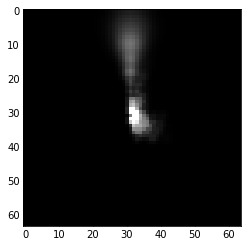

In [0]:
plt.imshow(render, cmap="gray")

In [0]:
tf.argmax(model(np.array([render])), axis=1)

<tf.Tensor: id=781000, shape=(1,), dtype=int64, numpy=array([9])>

In [0]:
np.array([render]).shape

(1, 64, 64)

# Encoder

In [0]:
def make_encoder():
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=(64,64)))
    model.add(layers.Dense(3*3*256, use_bias=False))
    model.add(layers.Dense(3*3*256, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((3, 3, 256)))
    assert model.output_shape == (None, 3, 3, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 3, 3, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 6, 6, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    model.add(layers.Reshape((144,)))
    assert model.output_shape == (None, 144)

    return model

In [0]:
encoder = make_encoder()

In [0]:
digits = [random.randint(0, 10) for i in range(5)]
test_digits = [digit_to_image(i) for i in digits]

In [0]:
test_encodings = encoder(np.array(test_digits), training=False)

In [0]:
test_encoded_images = tf.map_fn(grid.render_tensor, test_encodings)

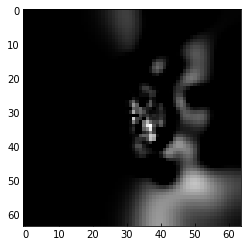

In [0]:
plt.imshow(test_encoded_images[0], cmap='gray')

In [0]:
model(test_encoded_images)

<tf.Tensor: id=781812, shape=(5, 10), dtype=float32, numpy=
array([[1.69338647e-03, 7.07752770e-03, 3.71685885e-02, 3.88449687e-03,
        1.21258780e-01, 2.74673581e-01, 9.52269242e-04, 5.28794110e-01,
        7.69114195e-05, 2.44204309e-02],
       [1.64275384e-03, 6.57591131e-03, 3.41081545e-02, 3.83988209e-03,
        1.06118821e-01, 2.86614627e-01, 8.71025841e-04, 5.36198139e-01,
        7.58943352e-05, 2.39548236e-02],
       [1.91507256e-03, 6.23675855e-03, 3.93285006e-02, 4.46504727e-03,
        1.16366468e-01, 2.99052507e-01, 1.04238826e-03, 5.08514643e-01,
        8.82378663e-05, 2.29903590e-02],
       [1.80265214e-03, 7.32946955e-03, 3.79846282e-02, 4.29531606e-03,
        1.23752415e-01, 2.80403286e-01, 1.02281442e-03, 5.17143011e-01,
        8.72970559e-05, 2.61790715e-02],
       [1.85515534e-03, 6.65680878e-03, 3.80637087e-02, 4.53819428e-03,
        1.16856381e-01, 2.80813456e-01, 1.00249972e-03, 5.22901237e-01,
        9.59522513e-05, 2.72165500e-02]], dtype=float32)

# Loss


In [0]:
cross_entropy = tf.keras.losses.CategoricalCrossentropy()

In [0]:
def encoder_loss(input_digit, output_digit):
    return cross_entropy(input_digit, output_digit)

In [0]:
encoder_optimizer = tf.keras.optimizers.Adam(1e-4)


# Checkpoints

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(encoder_optimizer=encoder_optimizer,
                                 encoder=encoder)

# Training

In [0]:
EPOCHS = 20
noise_dim = 10
num_examples_to_generate = 16

display_digits = np.array([i for i in range(10)])
display_digit_images = np.array(list(map(digit_to_image, display_digits)))

In [0]:
@tf.function
def train_step(digit_images):
    with tf.GradientTape() as enc_tape:
      encodings = encoder(digit_images, training=True)
      encoded_images = tf.map_fn(grid.render_tensor, encodings)
      #print(encoded_images.shape)
      
      output_digits = model(encoded_images)
      expected_digits = model(digit_images)
      #output_digits = tf.argmax(model(encoded_images), axis=1)
      #expected_digits = tf.argmax(model(digit_images), axis=1)
      #print(expected_digits)
      #print(output_digits)

      enc_loss = encoder_loss(expected_digits, output_digits)
      #print(enc_loss)

    gradients_of_encoder = enc_tape.gradient(enc_loss, encoder.trainable_variables)
    #print(gradients_of_encoder)

    encoder_optimizer.apply_gradients(zip(gradients_of_encoder, encoder.trainable_variables))

In [0]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(5,3))

  for i in range(predictions.shape[0]):
      plt.subplot(2, 5, i+1)
      plt.imshow(grid.render(predictions[i, :]), cmap='gray')
      plt.title(i)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for i in range(12):
      digits = np.random.randint(0, 10, (256,))
      digit_images = np.array(list(map(digit_to_image, digits)))
      train_step(digit_images)
      #print("BATCH DONE")

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(encoder,
                             epoch + 1,
                             display_digit_images
                             )

    # Save the model every 15 epochs
    if (epoch + 1) % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(encoder,
                           epochs,
                           display_digit_images)

# Training

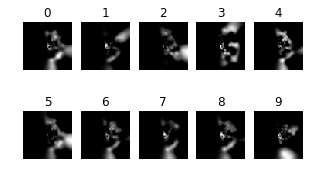

Time for epoch 11 is 81.18383741378784 sec


In [0]:
#%%time
train(train_dataset, EPOCHS)